<a href="https://colab.research.google.com/github/AhsanFarooq00/Innovative_Deep_Learning_Models_for_Brain_Tumor_Diagnosis-/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import os
import random
from PIL import Image, ImageEnhance, ImageOps
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Training/'
test_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing/'

train_paths = []
train_labels = []

# Iterate over each label (subdirectory) in the training directory
for label in os.listdir(train_dir):
  # Iterate over each image file in the label subdirectory
    for image in os.listdir(train_dir+label):
      # Append the full image path to the train_paths list
        train_paths.append(train_dir+label+'/'+image)
        # Append the label to the train_labels list
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
# Convert to DataFrame
train_df = pd.DataFrame({
    'Image Path': train_paths,
    'Class Label': train_labels
})

# Distribution Of Image Data

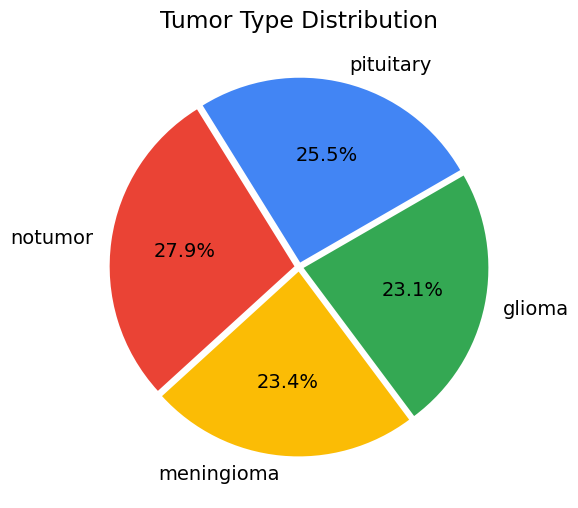

In [ ]:
def plot_tumor_distribution(train_labels):
    plt.figure(figsize=(8, 6))
    colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
    plt.rcParams.update({'font.size': 14})

    labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
    sizes = [len([x for x in train_labels if x == label]) for label in labels]

    plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%',
            explode=(0.025, 0.025, 0.025, 0.025), startangle=30)

    plt.title('Tumor Type Distribution')
    plt.show()

plot_tumor_distribution(train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
# Convert to DataFrame
test_df = pd.DataFrame({
    'Image Path': test_paths,
    'Class Label': test_labels
})

**Distribution of Data in training and testing**

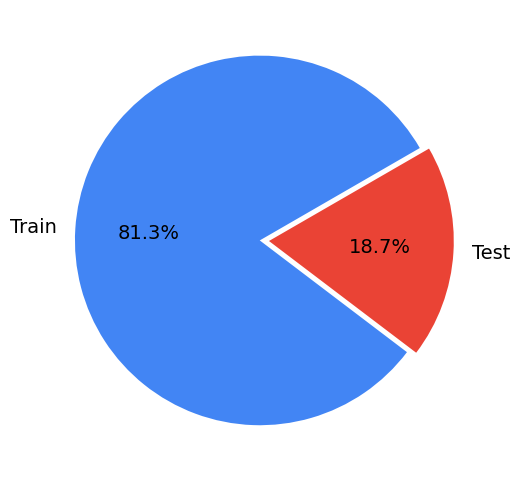

In [ ]:
plt.figure(figsize=(8,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# Spliting the Data

In [ ]:
valid_df, ts_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class Label'])

In [ ]:
# Parameters
batch_size = 32
img_size = (128, 128)
brightness_range = (0.8, 1.2)
rescale_factor = 1/255
num_classes = 4  # Example number of classes
epochs = 10   # Number of epochs in training

# Data Augmentation

In [ ]:
# Define data augmentation parameters for training
train_data_gen_args = dict(
    rescale=rescale_factor,
    brightness_range=brightness_range,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Define data augmentation parameters for validation and testing (usually less augmentation)
valid_test_data_gen_args = dict(rescale=rescale_factor)

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(**train_data_gen_args)
valid_test_gen = ImageDataGenerator(**valid_test_data_gen_args)


In [ ]:
# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'  # Assuming you have categorical labels
    )

    valid_gen = valid_test_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )

    test_gen_flow = valid_test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=16,
        target_size=img_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, valid_gen, test_gen_flow

# Create generators
train_gen, valid_gen, test_gen_flow = create_generators(train_df, valid_df, ts_df, batch_size, img_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


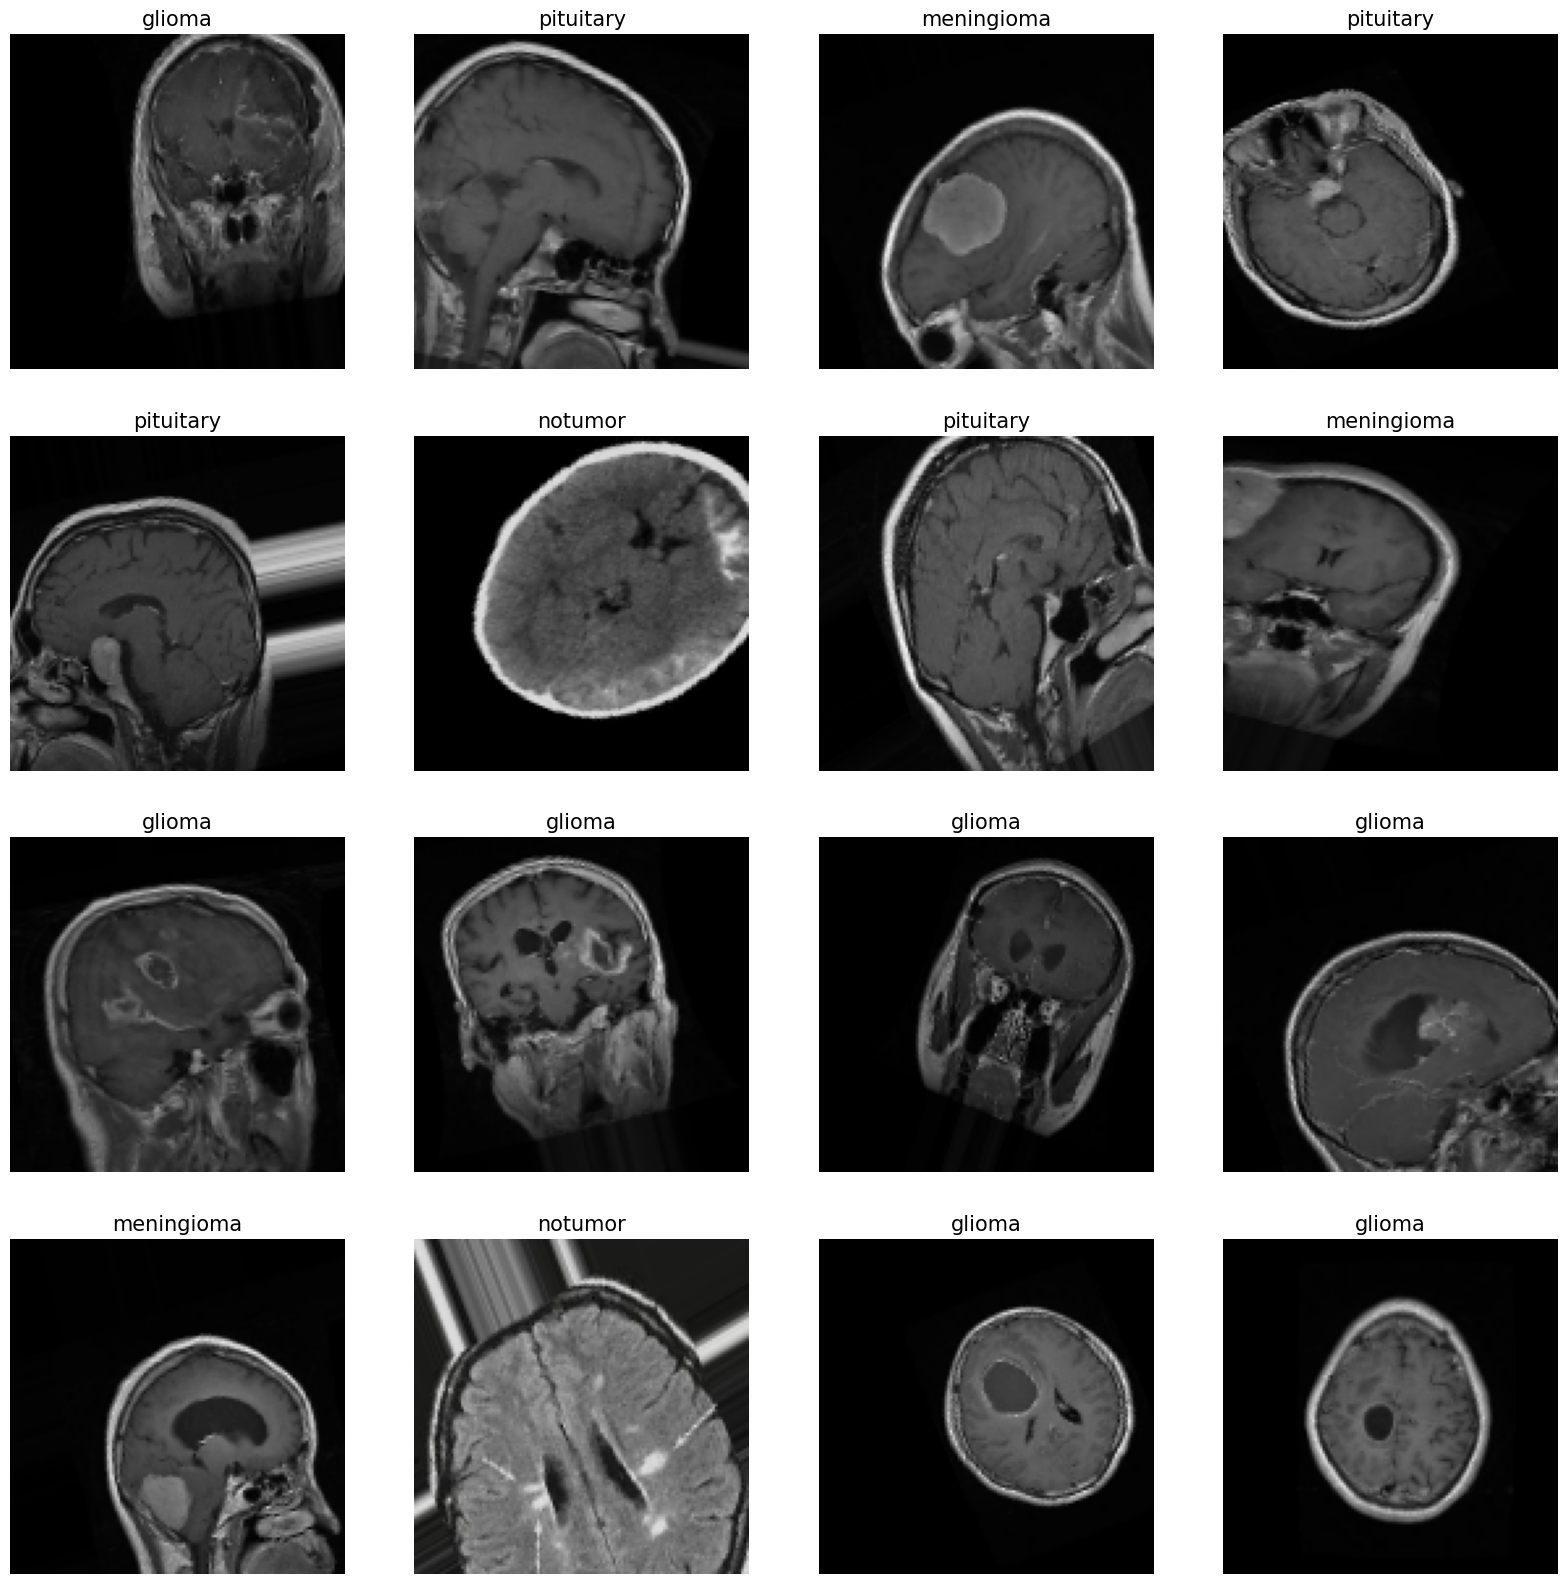

In [ ]:
# Visualize some augmented images from the training generator
images, labels = next(train_gen)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(20, 20))
for i in range(min(len(images), 16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    class_name = class_names[np.argmax(labels[i])]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')
plt.show()


# CNN Model Design

In [ ]:
# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flatten the output
model.add(Flatten())

# Add fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,602,692 (9.93 MB)

 Trainable params: 2,602,692 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/10
179/179 [==============================] - 3453s 19s/step - loss: 1.0721 - accuracy: 0.5049 - val_loss: 1.2869 - val_accuracy: 0.5038
Epoch 2/10
179/179 [==============================] - 56s 312ms/step - loss: 0.8445 - accuracy: 0.6455 - val_loss: 0.8522 - val_accuracy: 0.6489
Epoch 3/10
179/179 [==============================] - 56s 314ms/step - loss: 0.7503 - accuracy: 0.6887 - val_loss: 0.7932 - val_accuracy: 0.6870
Epoch 4/10
179/179 [==============================] - 56s 310ms/step - loss: 0.6721 - accuracy: 0.7227 - val_loss: 0.5796 - val_accuracy: 0.7634
Epoch 5/10
179/179 [==============================] - 59s 331ms/step - loss: 0.6234 - accuracy: 0.7472 - val_loss: 0.7811 - val_accuracy: 0.7053
Epoch 6/10
179/179 [==============================] - 56s 312ms/step - loss: 0.5513 - accuracy: 0.7738 - val_loss: 1.8491 - val_accuracy: 0.5069
Epoch 7/10
179/179 [==============================] - 58s 322ms/step - loss: 0.5414 - accuracy: 0.7798 - val_loss: 0.5887 - val_ac